# Assignment 2
In this task you will train an SVM and a neural network, which will be able to predict how much you will like a given song. This you will do by training on two sets of data: one set of songs you like, and one set of songs you dislike.

### Dataset
**Task:** If you have not already done so, head back to dataset_config.py and uncomment 10-15 playlists representing genres you do do not like. Do this is in the list stored in annoying_songs. The greater the dataset, the better, but we do not want to spend too much time setting up the dataset in this workshop. The playlists contain different amount of songs. Try to end up with approximately 1500-2000 songs in the dataset, and a 50/50 distribution with likeable and annoying songs. When you run the data pre-processing cell, the number of songs in each set will be printed.

In [22]:
import nbimporter
nbimporter.options['only_defs'] = False
import importlib

import dataset_config
import features_config
from helpers_and_data_parsing import DIR_PLAYLIST_FEATURES, filter_features, split_dataset, label_songs, remove_duplicates, remove_training_set_tracks, load_pickle, plot_training_history

from keras.models import Sequential
from keras.layers import Dense, Dropout
import numpy as np
from keras.models import load_model
from keras.callbacks import EarlyStopping
import pandas as pd
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn import svm
import pickle

np.set_printoptions(threshold=np.nan)

np.random.seed(6)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
#pd.set_option('display.height', 1000)
pd.set_option('display.width', 1000)

In [25]:
'''
DATA PRE-PROCESSING
'''
def get_pre_processed_data():
    importlib.reload(dataset_config)
    # Remove duplicates
    x_likeable = remove_duplicates(dataset_config.likeable_songs)
    x_annoying = remove_duplicates(dataset_config.annoying_songs)

    print("Number of likeable songs in training dataset %i" % len(x_likeable))
    print("Number of annoying songs in training dataset %i\n" % len(x_annoying))

    # Filter out chosen features and omit metadata such as song name and artist
    x_likeable_data = filter_features(x_likeable)
    x_annoying_data = filter_features(x_annoying)

    # Assign labels
    y_likeable = label_songs(x_likeable_data, 1)
    y_annoying = label_songs(x_annoying, 0)

    # Create list containing entire dataset input
    x_data = np.array(x_likeable_data + x_annoying_data)
    y_labels = np.array(y_likeable + y_annoying)

    # Normalize input training data
    x_data = StandardScaler().fit_transform(x_data)

    # Randomize data and split into training, validation and test set
    x_train, y_train, x_val, y_val, x_test, y_test = split_dataset(x_data, y_labels, 0.1, 0.1)
    
    return x_train, y_train, x_val, y_val, x_test, y_test

_ = get_pre_processed_data()

Unpickling playlists
 |XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX| 100.0% 
Unpickling playlists
 |XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX| 100.0% 
Number of likeable songs in training dataset 100
Number of annoying songs in training dataset 65



### SVM
We are going for an easy start by setting up an out-of-the-box SVM, which is only a few lines of code using the scikit-learn framework. You will get to play around a little more with the neural network.

**Tasks:** In the following cells are some todos. You will have to finish the code to run the SVM.
1. Instantiate an SVM object with this line: svm.SVC(probability=True), and store in the clf variable.

2. Train the SVM by calling .fit() on the SVM object and pass the training set (x_train) and labels (y_train) as arguments.

3. Store the prediction results on the validation set in val_score by calling .score() and passing the validation set and labels as arguments. 

4. Run the cell and you will get prediction accuracies on the training set and validation set. The model is automatically after training.

In [32]:
'''
Train SVM model
'''
importlib.reload(features_config)
x_train, y_train, x_val, y_val, x_test, y_test = get_pre_processed_data()

# TODO: Instantiate SVM object using Sklearn framework
clf = None

# TODO: Train SVM by calling fit() and passing training set + labels ass arguments

# TODO: Output accuracy on validation set by calling score() and passing validation set + label as arguments
val_score = ""

# TODO: Output accuracy on validation set by calling score() and passing validation set + label as arguments
test_score = ""

print('Validation accuracy of SVM: ' + str(val_score))
print('Test accuracy of SVM: ' + str(test_score))

filehandler = open('./svm_model.pkl', 'wb')
pickle.dump(clf, filehandler)


Unpickling playlists
 |XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX| 100.0% 
Unpickling playlists
 |XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX| 100.0% 
Number of likeable songs in training dataset 100
Number of annoying songs in training dataset 65

Validation accuracy of SVM: 0.625
Test accuracy of SVM: 


### Music recommendation

Result-wise, this is where we get to the interesting part. Now we are going to use the model to output recommendations. For this, we have downloaded a large playlist containing around 8000 songs from different genres. In this context, we will use this to represent the “all the songs in the world” (we know it’s not). Unlike Spotify, we do not have simple access to the actual library of all songs in the world. We are going to run this playlist through our trained model. The model will then give us a probability score describing how likely it is that we will like the each song, based on patterns it captures. 

**Task:** Run the cell. The output will show 30 songs the model thinks you will like. For fun, it also shows you 30 songs you will definitely dislike with passion. Do the results seem to be right based on the songs you recognize (or don’t recognize)?

In [33]:
def music_recommendation_svm():
    # Training set
    x_likeable = remove_duplicates(dataset_config.likeable_songs)
    x_annoying = remove_duplicates(dataset_config.annoying_songs)
    
    world_songs = load_pickle(DIR_PLAYLIST_FEATURES + '/Mega List/world_songs.pkl')

    # Pre-process songs, as was done for training set
    world_songs_without_duplicates = remove_duplicates(world_songs)

    # Must also remove training set songs from world songs
    training_set = x_likeable + x_annoying
    world_songs_without_duplicates = remove_training_set_tracks(training_set, world_songs_without_duplicates)

    filehandler = open('./svm_model.pkl', 'rb')
    clf = pickle.load(filehandler)

    all_data = StandardScaler().fit_transform(np.array(filter_features(world_songs_without_duplicates)))
    y_pred_probability = clf.predict_proba(all_data)
    y_pred = clf.predict(all_data)

    # Find 30 songs, which are most likeable
    song_pred_mapping = [{
        'name': world_songs_without_duplicates[i]['name'],
        'artists': world_songs_without_duplicates[i]['artists'],
        'likeability_score': y_pred_probability[i][1],
    } for i in range(len(y_pred))]

    # Sort songs by likeability score
    song_pred_mapping_sorted_by_likeability = sorted(song_pred_mapping, key=lambda x: x['likeability_score'])

    # Extract 30 most likeable songs and 30 most annoying songs
    recommendations = list(reversed(song_pred_mapping_sorted_by_likeability[-30:]))
    thirty_most_annoying_songs = song_pred_mapping_sorted_by_likeability[:30]

    # Print most likeable and annoying songs
    print("\n------Your music recommendations-------")
    print(pd.DataFrame(recommendations)[['artists', 'name', 'likeability_score']])

    print("\n-------Songs you will definitely hate-------")
    print(pd.DataFrame(thirty_most_annoying_songs)[['artists', 'name', 'likeability_score']])
    print("")
music_recommendation_svm()

Number of training set tracks in world songs: 4

------Your music recommendations-------
                               artists                                               name  likeability_score
0                              [Pvris]                                       What's Wrong           0.880365
1                             [Weezer]                                         Happy Hour           0.877832
2                            [Santana]                                  Black Magic Woman           0.866853
3               [Joe Walsh, Barnstorm]                     Turn To Stone - Single Version           0.862327
4                       [Ugly Kid Joe]                      Cats in the Cradle - Acoustic           0.848032
5                     [The Beach Boys]              Wouldn't It Be Nice - 2000 - Remaster           0.844934
6                   [Seals and Crofts]                                      Summer Breeze           0.844306
7                          [Sam Cooke] 

### Neural network
**Task:** Below is a simple implementation of a neural network. Run the cell to train a model.

In [7]:
'''
Train neural network model
'''
importlib.reload(features_config)
x_train, y_train, x_val, y_val, x_test, y_test = get_pre_processed_data()
### TRAINING ###
# Create model

# TODO: Here you can modify the architecture of the neural network model and experiment with different parameters
save_model=False
model = Sequential()
model.add(Dense(1,  # TODO: Number of hidden layer neurons
                input_dim=len(features_config.get_features()),
                activation='relu'))

# TODO: Possible to add additional neural network layers here
# TODO: Use model.add(Dense(number of hidden layer neurons, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Output layer

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# TODO: Optional; add early stopping as callback
history = model.fit(x=x_train,
                    y=y_train,
                    validation_data=[x_val, y_val],
                    batch_size=50,  # Number of data samples to run through network before parameter update
                    epochs=50,  # TODO: Number of times to run entire training set through network
                    shuffle=True,
                    callbacks=[]
                    ).history

score = model.evaluate(x_test, y_test, batch_size=50)  # Evaluate model on test set
print('Test loss:%f' % (score[0]))
print('Test accuracy:%f' % (score[1]))

if save_model:
    model.save('./nn_model.h5')
    print("Model saved")




Unpickling playlists
 |XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX| 100.0% 
Unpickling playlists
 |XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX| 100.0% 
Number of likeable songs in training dataset 100
Number of annoying songs in training dataset 65

Train on 133 samples, validate on 16 samples
Epoch 1/50
133/133 [==============================] - 0s 2ms/step - loss: 0.6855 - acc: 0.6015 - val_loss: 0.6755 - val_acc: 0.5625
Epoch 2/50
133/133 [==============================] - 0s 50us/step - loss: 0.6848 - acc: 0.6241 - val_loss: 0.6755 - val_acc: 0.5625
Epoch 3/50
133/133 [==============================] - 0s 50us/step - loss: 0.6844 - acc: 0.6241 - val_loss: 0.6756 - val_acc: 0.5625
Epoch 4/50
133/133 [==============================] - 0s 50us/step - loss: 0.6839 - acc: 0.6241 - val_loss: 0.6757 - val_acc: 0.5625
Epoch 5/50
133/133 [==============================] - 0s 49u

**Tasks**: 
The following cell will display the training graphs.

1. Try out different parameter values and architectures for the neural network. For example, you can make the model more complex by adding hidden layers. This you can do by adding Dense() layers to the model. You can also choose a larger number of neurons in the hidden layers.


2. Study the outputted graphs while trying different values. They show the amount of loss (error) and accuracy for the training set and validation set during training. Do you see any changes, for the better or worse, as a result of your decisions?
    - The graphs may not say much before you train the models for more than one epoch. Crank it up, friend.
    - The number of hidden neurons to choose is not straightforward, but there are some rules of thumb. Usually it should be somewhere between the size of the input layer and the size of the output layer
    
    The initial setup only has one neuron in a single hidden layer. Try increasing this number. Does your model learn more?
    
    
3. When you are happy with your model, you can save it by changing the argument for the save_model variable from False to True, and re-running the training cell.

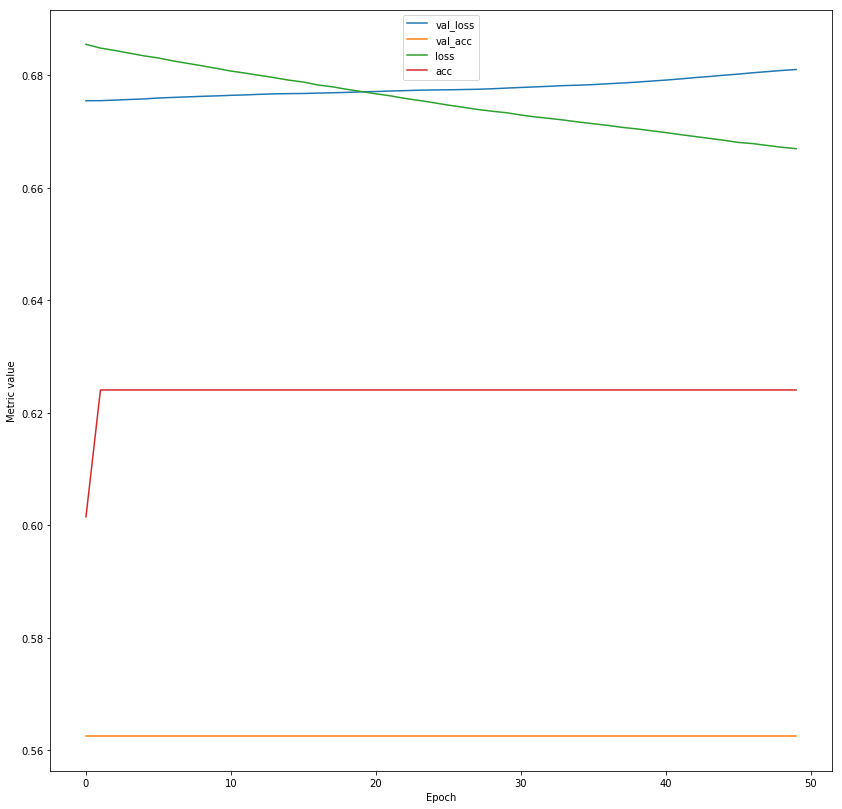

In [8]:
plot_training_history(history)

In [15]:
def music_recommendation_nn(model_path='./nn_model.h5'):
    importlib.reload(dataset_config)
    # Training set
    x_likeable = remove_duplicates(dataset_config.likeable_songs)
    x_annoying = remove_duplicates(dataset_config.annoying_songs)
    
    model = load_model(model_path)
    world_songs = load_pickle(DIR_PLAYLIST_FEATURES + '/Mega List/world_songs.pkl')

    # Pre-process songs, as was done for training set
    world_songs_without_duplicates = remove_duplicates(world_songs)

    # Must also remove training set songs from world songs
    training_set = x_likeable + x_annoying
    world_songs_without_duplicates = remove_training_set_tracks(training_set, world_songs_without_duplicates)

    x_data = StandardScaler().fit_transform(np.array(filter_features(world_songs_without_duplicates)))
    y_pred = model.predict(x_data, batch_size=50)

    # Find 30 songs, which are most likeable
    song_pred_mapping = [{
        'name': world_songs_without_duplicates[i]['name'],
        'artists': world_songs_without_duplicates[i]['artists'],
        'likeability_score': y_pred[i],
    } for i in range(len(y_pred))]

    # Sort songs by likeability score
    song_pred_mapping_sorted_by_likeability = sorted(song_pred_mapping, key=lambda x: x['likeability_score'])

    # Extract 30 most likeable songs and 30 most annoying songs
    recommendations = song_pred_mapping_sorted_by_likeability[-30:]
    thirty_most_annoying_songs = song_pred_mapping_sorted_by_likeability[:30]

    # Print most likeable and annoying songs
    print("\n------Your music recommendations-------")
    print(pd.DataFrame(recommendations)[['artists', 'name', 'likeability_score']])

    print("\n-------Songs you will definitely hate-------")
    print(pd.DataFrame(thirty_most_annoying_songs)[['artists', 'name', 'likeability_score']])
    print("")

music_recommendation_nn()

Unpickling playlists
 |XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX| 100.0% 
Unpickling playlists
 |XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX| 100.0% 
Number of training set tracks in world songs: 4

------Your music recommendations-------
                                     artists                                               name likeability_score
0                               [Eric Prydz]                                           Liberate       [0.8996445]
1                                     [STOP]                                          Feel Free       [0.8996952]
2                                [Vengaboys]                   We like to Party! (The Vengabus)      [0.90018415]
3                                [Pete Tong]                                           Insomnia      [0.90127385]
4                     [Blood Groove & Kikis]                               

### Optional neural network tasks
Already done, huh? Try out these neat tricks to train a better model.
#### Dropout
By adding more layers or neurons, your model expands its capacity of capturing patterns in the training set, but this may lead to overfitting. You can counteract this by adding a Dropout layer after your hidden layer. This will omit a certain percentage of the neurons in your hidden layer in every iteration. Practically speaking, this simulates the use of several neural networks for training, and thus reduces the chance of overfitting. 

Use dropout by adding an instance of Dropout(rate) to you model, exactly as you have done with Dense layers earlier.


#### Early stopping
Depending on the configuration and your architecture, you may see from your training graphs that if you train for many epochs the performance on the validation set stops at a certain point. If this is the model architecture you are going for, then it would be a good idea to stop training at the point where performance stops to improve. Do this by using early stopping, which monitors a certain value and stops training when that value stops to improve. 

Use early stopping by adding an instance of EarlyStopping(monitor=”val_loss”, patience=2) in the list of callbacks for your model. This will monitor the validation loss and stop training if it does not improve over two epochs, thus saving the best possible model following this configuration.